### Задание

#### 1. Получите данные и загрузите их в рабочую среду.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import stats

In [2]:
glass_data = pd.read_csv('glass.csv')

#### 2. Проведите первичный анализ.

In [3]:
glass_data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [4]:
glass_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


##### а) Проверьте количество записей для каждого класса.

In [22]:
class_counts = glass_data['Type'].value_counts().sort_index()
print("Количество записей для каждого класса:")
print(class_counts)

Количество записей для каждого класса:
1    70
2    76
3    17
5    13
6     9
7    29
Name: Type, dtype: int64


Видим, что наибольшее количество данных относится к двум классам: 1 и 2.

#### Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [6]:
X, y = glass_data.iloc[:, :-1], glass_data['Type']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 4. Обучите модель дерева решений `RandomForestClassifier` на обучающем множестве.

In [8]:
random_forest_model = RandomForestClassifier(random_state=42)

In [9]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (`accuracy`).

In [10]:
y_test_pred_forest = random_forest_model.predict(X_test)

In [11]:
accuracy_score(y_test, y_test_pred_forest)

0.8372093023255814

#### 6. Обработайте выбросы в данных.

***а) Визуализируйте распределение значений для каждой переменной. Есть ли признаки с нормальным распределением?  
b) Исследуйте признаки на выбросы несколькими способами.  
c) Удалите выбросы. Посчитайте процент удаленных записей от общего числа записей для каждого класса.***

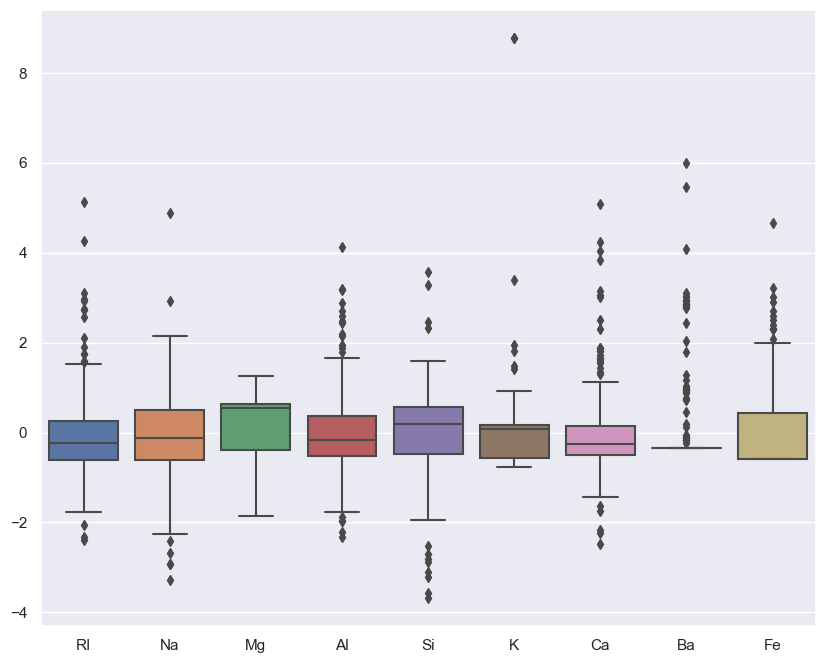

In [12]:
# Приведём данные к одному масштабу
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns = X.columns)

# Выполним визуализацию через boxplot
plt.figure(figsize=(10, 8))
sns.set(style="darkgrid")
sns.boxplot(data=data_scaled)
plt.show()

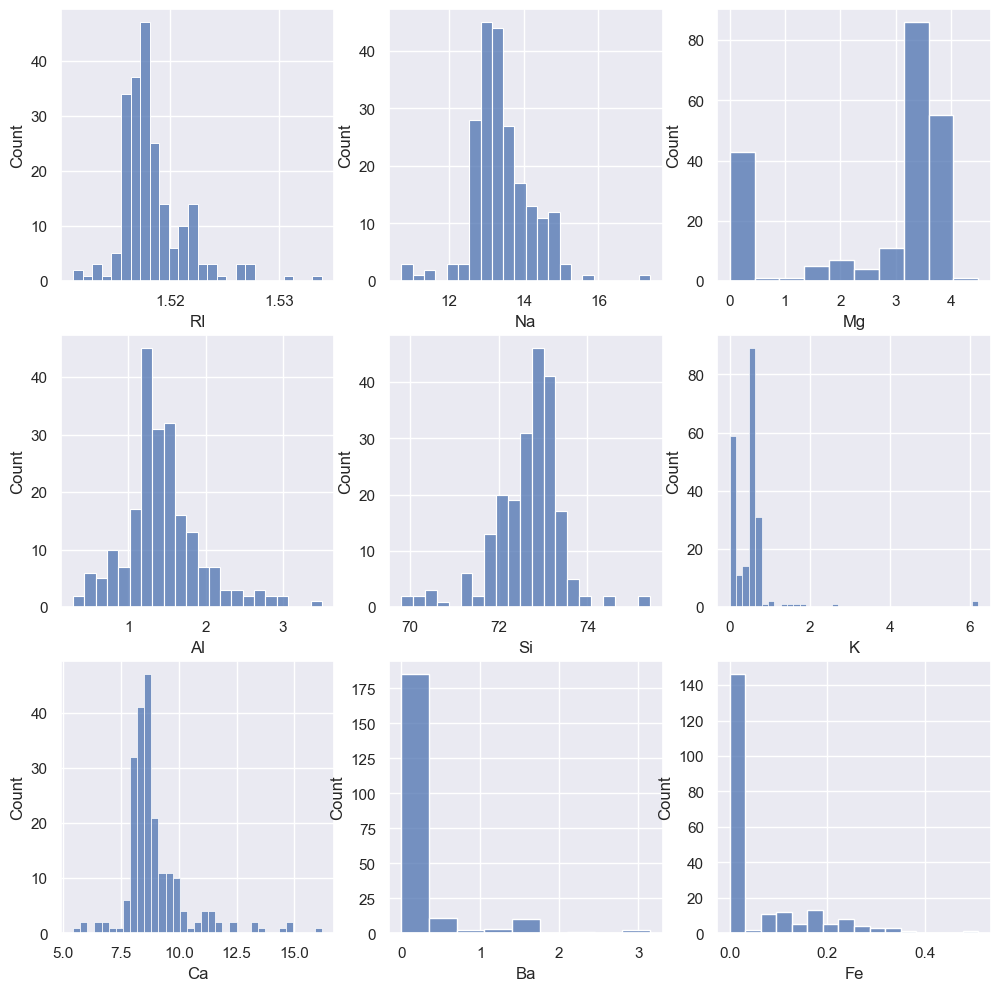

In [13]:
# Выполним визуализацию через histplot
plt.figure(figsize=(12, 12))
for i, column in enumerate(X.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(X[column])   

Больше всего, нормальное распределение напоминают распределения следующих признаков: 'RI', 'Na', 'Al', 'Si', 'Ca'.

In [14]:
# Запишем функцию для поиска выбросов через межквартильный размах
def remove_outliers(df, features):
    for feature in features:
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_out = df[df[feature].between(lower_bound, upper_bound, inclusive='both')]
    return df_out

In [15]:
# Произведём обработку выбросов в данных с использованием межквартильного размаха
outlier_features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
data_no_outliers_iqr = remove_outliers(glass_data, outlier_features)

# Сравним размеры данных до и после удаления выбросов
percentage_removed = (1 - len(data_no_outliers_iqr) / len(glass_data)) * 100

print(f'Общий процент удаленных записей: {percentage_removed:.2f}%')
print("Процент удаленных записей от общего числа записей для каждого класса:")
print((1 - data_no_outliers_iqr['Type'].value_counts() / class_counts) * 100)

Общий процент удаленных записей: 5.61%
Процент удаленных записей от общего числа записей для каждого класса:
1     4.285714
2     7.894737
3     5.882353
5    15.384615
6     0.000000
7     0.000000
Name: Type, dtype: float64


In [16]:
# Произведём обработку выбросов в данных с использованием Z-Score
data_no_outliers_zscore = glass_data[(np.abs(stats.zscore(glass_data.drop('Type', axis=1))) < 3).all(axis=1)]
percentage_removed = (1 - len(data_no_outliers_zscore) / len(glass_data)) * 100

# Сравним размеры данных до и после удаления выбросов
print(f'Общий процент удаленных записей: {percentage_removed:.2f}%')
print("Процент удаленных записей от общего числа записей для каждого класса:")
print((1 - data_no_outliers_zscore['Type'].value_counts() / class_counts) * 100)

Общий процент удаленных записей: 9.35%
Процент удаленных записей от общего числа записей для каждого класса:
1     0.000000
2    10.526316
3     5.882353
5    30.769231
6    11.111111
7    20.689655
Name: Type, dtype: float64


#### 7. Повторите п. 4, п. 5.

In [17]:
# Запишем функцию, для выполнения пунктов 4 и 5
def accuracy_counting(data):
    X = data.iloc[:, :-1]
    y = data['Type']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    
    print('Accuracy:', accuracy)

In [18]:
# Точность модели без удаления выбросов
accuracy_counting(glass_data)

Accuracy: 0.8372093023255814


In [19]:
# Точность модели с удалением выбросов через межквартильный размах
accuracy_counting(data_no_outliers_iqr)

Accuracy: 0.8292682926829268


In [20]:
# Точность модели с удалением выбросов через Z-Score
accuracy_counting(data_no_outliers_zscore)

Accuracy: 0.7435897435897436


#### 8. Сформулируйте выводы по проделанной работе.

Исследование данных на выбросы важно, так как выбросы могут исказить результаты модели, ухудшая ее предсказательную способность. Однако, удаление выбросов также может привести к потере информации и сужению обобщающей способности модели.  
Плюсы: повышение качества модели, улучшение интерпретации данных,  уменьшение влияния шумовых данных.
Минусы: потеря информации, изменение распределения данных, возможное искажение реальности.